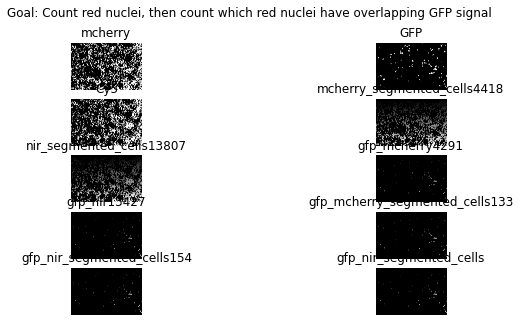

In [11]:
## This python script counts the number of GFP cells
# that is overlapped with the red cells in a given microscopy image

import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
from scipy import ndimage as ndi
import cv2
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)
import os
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

img = Image.open('WellA02_PointA02_0000_ChannelTRITC,GFP ,CY5_Seq0001.tiff')
frames = []
for i in range(3):
    img.seek(i)
    frames.append(img.copy())
# Choose your mCherry cells
mcherry = img_as_ubyte(frames[0])
# Choose your mCherry+GFP cells
gfp = img_as_ubyte(frames[1])
# Choose your mCherry+cy5 cells
nir = img_as_ubyte(frames[2])

# Convert the images into a grayscale image
mcherry = rgb2gray(mcherry)
gfp = rgb2gray(gfp)
nir = rgb2gray(nir)

# Setting up the threshold array to identify the cells
# The class might be modified depending on the cell image, the range is 2 to 4
mcherry_thresholds = filters.threshold_multiotsu(mcherry, classes=2)
mcherry = mcherry > mcherry_thresholds[0]
gfp_thresholds = filters.threshold_multiotsu(gfp, classes=2)
gfp = gfp > gfp_thresholds[0]
nir_thresholds = filters.threshold_multiotsu(nir, classes=2)
nir = nir > nir_thresholds[0]

# Create a distance array to segment the cells from overlapping one
# The minimum distance might be modified depending on the cell image, the range is 5 to 6
# The cells are segmented and watershed for counting
mcherry_distance = ndi.distance_transform_edt(mcherry)
mcherry_local_max_coords = feature.peak_local_max(mcherry_distance, min_distance=5)
mcherry_local_max_mask = np.zeros(mcherry_distance.shape, dtype=bool)
mcherry_local_max_mask[tuple(mcherry_local_max_coords.T)] = True
mcherry_markers = measure.label(mcherry_local_max_mask)
mcherry_segmented_cells = segmentation.watershed(-mcherry_distance, 
                                                 mcherry_markers, mask=mcherry)

nir_distance = ndi.distance_transform_edt(nir)
nir_local_max_coords = feature.peak_local_max(nir_distance, min_distance=5)
nir_local_max_mask = np.zeros(mcherry_distance.shape, dtype=bool)
nir_local_max_mask[tuple(nir_local_max_coords.T)] = True
nir_markers = measure.label(nir_local_max_mask)
nir_segmented_cells = segmentation.watershed(-nir_distance, nir_markers, mask=nir)

# Mask the two images together
gfp_mcherry = mcherry_segmented_cells * gfp
gfp_nir = nir_segmented_cells * gfp

# Remove small objects, the higher the unit of morphology, the larger the objects removed
morp = morphology.disk(4.5)     
small_obj1 = morphology.white_tophat(gfp_mcherry, morp)
small_obj2 = morphology.white_tophat(gfp_nir, morp)
gfp_mcherry = gfp_mcherry - small_obj1
gfp_nir = gfp_nir - small_obj2

# Do the same process for the new overlap image as above
gfp_mcherry_distance = ndi.distance_transform_edt(gfp_mcherry)
gfp_mcherry_local_max_coords = feature.peak_local_max(gfp_mcherry_distance, min_distance=5)
gfp_mcherry_local_max_mask = np.zeros(gfp_mcherry_distance.shape, dtype=bool)
gfp_mcherry_local_max_mask[tuple(gfp_mcherry_local_max_coords.T)] = True
gfp_mcherry_markers = measure.label(gfp_mcherry_local_max_mask)
gfp_mcherry_segmented_cells = segmentation.watershed(-gfp_mcherry_distance, 
                                                     gfp_mcherry_markers, mask=gfp_mcherry)

gfp_nir_distance = ndi.distance_transform_edt(gfp_nir)
gfp_nir_local_max_coords = feature.peak_local_max(gfp_nir_distance, min_distance=5)
gfp_nir_local_max_mask = np.zeros(gfp_nir_distance.shape, dtype=bool)
gfp_nir_local_max_mask[tuple(gfp_nir_local_max_coords.T)] = True
gfp_nir_markers = measure.label(gfp_nir_local_max_mask)
gfp_nir_segmented_cells = segmentation.watershed(-gfp_nir_distance, 
                                                     gfp_nir_markers, mask=gfp_nir)


# Create a 4 subplot figures that show the images transformed and the number of cells
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 5))
fig.suptitle('Goal: Count red nuclei, then count which red nuclei have overlapping GFP signal')
ax[0,0].imshow(mcherry, cmap='gray')
ax[0,0].set_title('mcherry')
ax[0,0].axis('off')
ax[0,1].imshow(gfp, cmap='gray')
ax[0,1].set_title('GFP')
ax[0,1].axis('off')
ax[1,0].imshow(nir, cmap='gray')
ax[1,0].set_title('Cy5')
ax[1,0].axis('off')

ax[1,1].imshow(mcherry_segmented_cells, cmap='gray')
ax[1,1].set_title('mcherry_segmented_cells' + str(mcherry_segmented_cells.max()))
ax[1,1].axis('off')
ax[2,0].imshow(nir_segmented_cells, cmap='gray')
ax[2,0].set_title('nir_segmented_cells' + str(nir_segmented_cells.max()))
ax[2,0].axis('off')
ax[2,1].imshow(gfp_mcherry, cmap='gray')
ax[2,1].set_title('gfp_mcherry' + str(gfp_mcherry.max()))
ax[2,1].axis('off')
ax[3,0].imshow(gfp_nir, cmap='gray')
ax[3,0].set_title('gfp_nir'+ str(gfp_nir.max()))
ax[3,0].axis('off')
ax[3,1].imshow(gfp_mcherry_segmented_cells, cmap='gray')
ax[3,1].set_title('gfp_mcherry_segmented_cells'+ str(gfp_mcherry_segmented_cells.max()))
ax[3,1].axis('off')
ax[4,0].imshow(gfp_nir_segmented_cells, cmap='gray')
ax[4,0].set_title('gfp_nir_segmented_cells' + str(gfp_nir_segmented_cells.max()))
ax[4,0].axis('off')

ax[4,1].imshow(gfp_nir_segmented_cells, cmap='gray')
ax[4,1].set_title('gfp_nir_segmented_cells')
ax[4,1].axis('off')
plt.show()
